---
file_format: mystnb
kernelspec:
  name: python3
mystnb:
    execution_mode: 'inline'
---

# Ghana Exploratory Data Analysis

In [6]:
# ! pip install pandas
# ! pip install geopandas
# ! pip install folium
# ! pip install matplotlib
# ! pip install pyogrio
# ! pip install fiona
# ! pip install scikit-learn
! pip install myst-nb

   ---------------------------------------- 0.0/79.9 kB ? eta -:--:--
   ---------------------------------------- 79.9/79.9 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/77.2 kB ? eta -:--:--
   ---------------------------------------- 77.2/77.2 kB ? eta 0:00:00
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   --------- ------------------------------ 0.8/3.2 MB 16.9 MB/s eta 0:00:01
   ----------------------- ---------------- 1.9/3.2 MB 20.3 MB/s eta 0:00:01
   ------------------------------------- -- 3.0/3.2 MB 21.6 MB/s eta 0:00:01
   ---------------------------------------- 3.2/3.2 MB 18.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/138.7 kB ? eta -:--:--
   ---------------------------------------- 138.7/138.7 kB ? eta 0:00:00
   ---------------------------------------

In [54]:
! pip list

Package            Version
------------------ --------
asttokens          2.4.0
attrs              23.2.0
backcall           0.2.0
branca             0.7.1
certifi            2024.2.2
charset-normalizer 3.3.2
click              8.1.7
click-plugins      1.1.1
cligj              0.7.2
colorama           0.4.6
comm               0.1.4
contourpy          1.2.1
cycler             0.12.1
debugpy            1.8.0
decorator          5.1.1
executing          2.0.0
fiona              1.9.6
folium             0.16.0
fonttools          4.51.0
GDAL               3.8.5
geopandas          0.14.3
idna               3.6
ipykernel          6.25.2
ipython            8.16.1
jedi               0.19.1
Jinja2             3.1.3
joblib             1.2.0
jupyter_client     8.3.1
jupyter_core       5.3.2
kiwisolver         1.4.5
MarkupSafe         2.1.5
matplotlib         3.8.4
matplotlib-inline  0.1.6
mkl-fft            1.3.8
mkl-random         1.2.4
mkl-service        2.4.0
nest-asyncio       1.5.8
numpy      

In [43]:
import pandas as pd
import geopandas as gpd
import os
import folium
from folium.plugins import MarkerCluster
import numpy as np
import branca.colormap as cm
import matplotlib.pyplot as plt
import fiona
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from scipy.stats import spearmanr

os.chdir(r"C:\Users\nial\OneDrive\ETH Zürich\Master Thesis")

### Load Data

Whole dataset

In [56]:
fields = ['pft_class', 'leaf_off_f', 'urban_pro','selected_a','sensitivit'
          ,'agbd', 'agbd_se', 'rh98', 'date', 'geometry']

df_ghana = gpd.read_file('GEDI_Ghana.geojson'
                         , driver = 'GeoJSON'
                         )
                         # , engine='pyogrio')

Random subsample of 10,000 rows

In [2]:
df_ghana_subsample = gpd.read_file('df_ghana_subsample.geojson'
                         , driver = 'GeoJSON'
                         , engine='pyogrio')

c:\Users\nial\anaconda3\envs\MasterThesis\Lib\site-packages\pyogrio\raw.py:194: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  result = ogr_read(


See unique columns:

In [ ]:
df_ghana.columns

Index(['pft_class', 'region_cla', 'leaf_off_f', 'urban_prop', 'agbd',
       'agbd_se', 'beam', 'elev_lowes', 'lat_lowest', 'lon_lowest',
       'selected_a', 'shot_numbe', 'sensitivit', 'solar_elev', 'rh98',
       'pattern', 'doy_sin', 'doy_cos', 'date', 'lat_cos', 'lat_sin',
       'lon_cos', 'lon_sin', 'geometry'],
      dtype='object')

Number of measurements by column

In [ ]:
df_ghana_subsample['pft_class'].value_counts()

pft_class
6    4782
2    3288
4     840
8     664
7     402
9      24
Name: count, dtype: int64

Median standard error by plant functional type (pft)

In [24]:
df_se_medians = df_ghana_subsample.groupby('pft_class')['agbd_se'].median().reset_index()
df_se_medians.rename(columns={'agbd_se': 'median_agbd_se'}, inplace=True)

df_se_medians.head(10)

pft_class  median_agbd_se
0          2       17.132369
1          4        4.178562
2          6        2.990576
3          7        3.005250
4          8        2.998887
5          9        4.213624

Note: we can infer the prediction stratum from pft_class, since: 

_"Footprint AGBD is generated for 32 combinations of plant functional type (PFT) and geographic world region using 13 linear models"_

### Plot Folium Map of data

In [ ]:
# prepare dict of colours
colour_crit = 'pft_class'
index = sorted([i for i in df_ghana_subsample[colour_crit].unique()])
colour_list = ['red', 'yellow', 'pink', 'chartreuse', 'orange','purple','blue']
colour_dict = {index:colour for index, colour in zip(index, colour_list)}

# Ghana tile
ghana_map = folium.Map(location=[7.9465, -1.0232], zoom_start=7)

# colour scale
# linear = cm.LinearColormap(colour_list, vmin=df_ghana[colour_crit].min(), vmax=df_ghana[colour_crit].max())
# step = cm.StepColormap(colour_list, index=index)

# plot rows
for _, row in df_ghana_subsample.iterrows():
    
    geom = row['geometry']
    colour_index = row[colour_crit]

    # if colour == 2: continue
    
    folium.CircleMarker(
          location=[geom.y, geom.x]
        # , popup=...
        , radius=3
        , fill=True
        , color=colour_dict[colour_index]
    ).add_to(ghana_map)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 130px; height: 180px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
                 ">&nbsp; Legend <br>
                 &nbsp; PFT 2 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:red"></i><br>
                 &nbsp; PFT 4 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:yellow"></i><br>
                 &nbsp; PFT 6 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:pink"></i><br>
                 &nbsp; PFT 7 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:chartreuse"></i><br>
                 &nbsp; PFT 8 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:orange"></i><br>
                 &nbsp; PFT 9 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:purple"></i><br>
                 &nbsp; PFT 11 &nbsp; <i class="fa fa-circle 
                                  fa-1x" style="color:blue"></i>
      </div>
     '''

ghana_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
ghana_map

In [ ]:
# df_ghana_subsample = df_ghana.sample(n=10000, replace=False)
# df_ghana_subsample = df_ghana_subsample.sample(frac=1, replace=False, random_state=42, axis=0)

In [ ]:
df_ghana_subsample.to_file("df_ghana_subsample.geojson", driver='GeoJSON')

### Plot standard errors against agbd

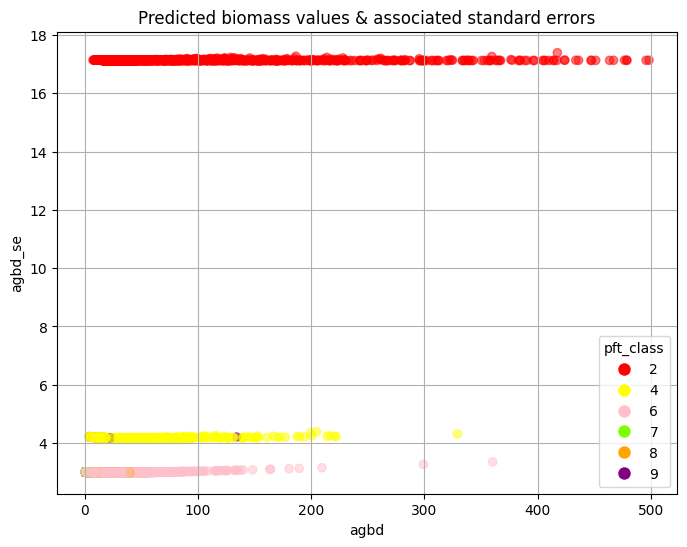

In [ ]:
scatter_colours = [colour_dict.get(colour_index, 'black') for colour_index in df_ghana_subsample[colour_crit]]

plt.figure(figsize=(8, 6))
plt.scatter(df_ghana_subsample['agbd'], df_ghana_subsample['agbd_se'], color=scatter_colours, alpha=0.5, label='Data')

p = np.polyfit(df_ghana_subsample['agbd'], df_ghana_subsample['agbd_se'], deg=3)
x_values = np.linspace(df_ghana_subsample['agbd'].min(), df_ghana_subsample['agbd'].max(), 100)
y_values = np.polyval(p, x_values)
# plt.plot(x_values, y_values, color='red', label='Cubic Line of Best Fit')

plt.title('Predicted biomass values & associated standard errors')
plt.xlabel('agbd')
plt.ylabel('agbd_se')

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for label, color in colour_dict.items()]
plt.legend(handles=legend_handles, title=colour_crit)

plt.grid(True)
plt.show()

In [ ]:
len(df_ghana_subsample['agbd_se'].unique())

4501

Recall that the standard error calculation is 

$$ \text{SE}_i = \sqrt{ \text{MSE}_k + \mathbf{X}_i \text{Cov}( \beta) \mathbf{X}_i^T } $$

Where:

* $i$ indexes a footprint
* $k$ indexes the stratum containing $i$
* $\text{MSE}_k$ is the $\text{MSE}$ from the linear regression model applied to prediction stratum $k$
* $\mathbf{X}_i$ is the row vector of relative height (RH) metrics for GEDI footprint $i$
* $\text{Cov}( \beta)$ is the covariance matrix for model parameters in transformed units

We observe in the plot that for this subset of data, the AGBD standard errors are clustered around three values. Yet there are 4501 unique `agbd_se` values. My hypothesis is that in the standard error calculation, the $\text{MSE}_k$ term dominates while the term involving $\mathbf{X}_i$ only makes a negligible contribution. Hence the `agbd_se` mainly indicates the goodness of fit of the model converting `rh98` to `agbd`. 

However, $\text{SE}_i$ is not back-transformed to the original units, so it is hard to interpret anything from the value itself.

Note how PFT classes are grouped:

* ENT: class 1
* EBT: class 2
* DNT: class 3 (not in Africa)
* DBT: class 4
* GSW: classes 5, 6, 11

`df_se_medians` suggests that class 2 is separate from the rest, classes 4 & 9 are together, and classes 6, 7 and 8 are together.

In [25]:
df_se_medians

pft_class  median_agbd_se
0          2       17.132369
1          4        4.178562
2          6        2.990576
3          7        3.005250
4          8        2.998887
5          9        4.213624

### Outlier Detection Experiment

Aim: we will deploy outlier detection methodologies from `scikit-learn` to get a feel for which rows the methods consider outliers.

We begin with the `LocalOutlierFactor()`, a density-based approach to detecting outliers. Per the sklearn website:

_The anomaly score of each sample is called the Local Outlier Factor. It measures the local deviation of the density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers._

Note that the `LocalOutlierFactor()` takes in numeric values only. We will reduce the dataframe to categorical and numerical columns:

Data Processing

In [26]:
# drop non-feature columns
drop_cols = [  'pattern', 'geometry', 'region_cla', 'elev_lowes', 'lat_lowest', 'lon_lowest', 'shot_numbe'
             , 'doy_sin', 'doy_cos', 'date', 'lat_cos', 'lat_sin', 'lon_cos', 'lon_sin']
df_ghana_subsample_lof = df_ghana_subsample.drop(drop_cols, axis=1)

# group pft_class
# {class:class_group}. class_group identifier = lowest number of class in group
class_group_dict = {2:2, 4:4, 9:4, 6:6, 7:6, 8:6}
df_ghana_subsample_lof['pft_class_group'] = df_ghana_subsample_lof.apply(lambda row: class_group_dict[row['pft_class']], axis=1)
df_ghana_subsample_lof.drop('pft_class', axis=1, inplace=True)

# one-hot encode the categorical columns
cat_cols = ['pft_class_group', 'beam', 'selected_a', 'leaf_off_f']
df_ghana_subsample_lof = pd.get_dummies(df_ghana_subsample_lof, columns=cat_cols)

Classify outliers

In [37]:
# fit LOF
clf = LocalOutlierFactor(n_jobs=20)
anomaly_clf = clf.fit_predict(df_ghana_subsample_lof)
anomaly_score_clf = clf.negative_outlier_factor_

# compute % classified as anomalies
perc_anom = (100 * sum(anomaly_clf == -1) / len(anomaly_clf))
print(f"{perc_anom}% of values are categorised as anomalies")

0.8% of values are categorised as anomalies


`sklearn` does not explicitly provide variable importance scores for LOF analysis. Hence we will fit a logisitic regression model to determine which variables are most important for determining outliers.

In [28]:
log_reg = LogisticRegression(penalty='l1', solver='liblinear')
log_reg.fit(df_ghana_subsample_lof, anomaly_clf)

LogisticRegression(penalty='l1', solver='liblinear')

View coefficient estimates of logistic regression fit

In [44]:
lr_coeffs = [item for sublist in log_reg.coef_.tolist() for item in sublist]
colnames = [c for c in log_reg.feature_names_in_]
lr_coeffs = {var:round(coef,3) for var, coef in zip(colnames,lr_coeffs)}

# sort in descending order of absolute value
# lr_coeffs = dict(sorted(lr_coeffs.items(), key=lambda item: abs(item[1]), reverse=True))
lr_coeffs

{'urban_prop': -0.302,
 'agbd': 0.036,
 'agbd_se': -0.121,
 'sensitivit': 3.73,
 'solar_elev': -0.018,
 'rh98': -0.031,
 'pft_class_group_2': 0.796,
 'pft_class_group_4': -0.924,
 'pft_class_group_6': 0.0,
 'beam_5': 0.026,
 'beam_6': 0.0,
 'beam_8': -0.148,
 'beam_11': 0.223,
 'selected_a_1': 0.0,
 'selected_a_2': 1.084,
 'selected_a_5': 0.0,
 'leaf_off_f_0': 1.799,
 'leaf_off_f_255': 0.0}

We should also consider how many non-zero observations we have per column:

In [31]:
non_zero_counts = df_ghana_subsample_lof.astype(bool).sum(axis=0)
non_zero_counts

urban_prop              69
agbd                 10000
agbd_se              10000
sensitivit           10000
solar_elev           10000
rh98                 10000
pft_class_group_2     3288
pft_class_group_4      864
pft_class_group_6     5848
beam_5                2225
beam_6                2245
beam_8                2487
beam_11               3043
selected_a_1          7845
selected_a_2          2034
selected_a_5           121
leaf_off_f_0          9902
leaf_off_f_255          98
dtype: int64

* `urban_prop` has a surprisingly large coefficient, given it is only non-zero for 69 / 10000 observations. 
* `agbd` and `agb_se` are not useful predictors
* `sensivity`, `leaf_off` and `pft_class_group` seem to be the most relevant predictors

###  Compare LOF classification with k-1 predictors

We will classify outliers with every subset of $k-1$ predictors. Then, we will rank the predictors by Jaccard score: $\frac{|A \cap B|}{|A \bigcup B|}$, where $A$ and $B$ are the set of indices of outliers classified with $k$ and $k-1$ predictors respectively.

In [51]:
# custom Jaccard score allows for differently-sized lists

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [52]:
anom_indices = df_ghana_subsample_lof.index[anomaly_clf == -1].tolist()
j_scores = dict()

for c in colnames:

    # omit predictor
    X = df_ghana_subsample_lof.drop(columns=[c])

    # fit LOF classifier
    clf_km1 = LocalOutlierFactor(n_jobs=20)
    anomaly_km1 = clf.fit_predict(X)
    anom_indices_km1 = df_ghana_subsample_lof.index[anomaly_km1 == -1].tolist()

    # store Jaccard score
    j_score = jaccard(anom_indices, anom_indices_km1)
    j_scores.update([(c,j_score)])

# j_scores = dict(sorted(j_scores.items(), key=lambda item: abs(item[1]), reverse=False))
j_scores

{'urban_prop': 0.36904761904761907,
 'agbd': 0.40625,
 'agbd_se': 0.875,
 'sensitivit': 1.0,
 'solar_elev': 0.09742120343839542,
 'rh98': 0.9146341463414634,
 'pft_class_group_2': 0.9753086419753086,
 'pft_class_group_4': 0.975,
 'pft_class_group_6': 0.9629629629629629,
 'beam_5': 0.9411764705882353,
 'beam_6': 0.963855421686747,
 'beam_8': 0.9080459770114943,
 'beam_11': 0.8888888888888888,
 'selected_a_1': 0.975609756097561,
 'selected_a_2': 0.975609756097561,
 'selected_a_5': 1.0,
 'leaf_off_f_0': 0.9875,
 'leaf_off_f_255': 0.9875}

There is no significant rank correlation between the absolute value of a coefficient from logistic regression and the k-to-(k-1) Jaccard score. Personally, I prefer the latter measurement, since we have not standardised units in the log fit.

In [59]:
rank_corr = spearmanr(list(j_scores.values()), [abs(v) for v in lr_coeffs.values()])
rank_corr

SignificanceResult(statistic=0.07624321315473259, pvalue=0.7636525773420824)

Sort the Jaccard scores in ascending value order:

In [60]:
j_scores_sorted = dict(sorted(j_scores.items(), key=lambda item: abs(item[1]), reverse=False))
j_scores_sorted

{'solar_elev': 0.09742120343839542,
 'urban_prop': 0.36904761904761907,
 'agbd': 0.40625,
 'agbd_se': 0.875,
 'beam_11': 0.8888888888888888,
 'beam_8': 0.9080459770114943,
 'rh98': 0.9146341463414634,
 'beam_5': 0.9411764705882353,
 'pft_class_group_6': 0.9629629629629629,
 'beam_6': 0.963855421686747,
 'pft_class_group_4': 0.975,
 'pft_class_group_2': 0.9753086419753086,
 'selected_a_1': 0.975609756097561,
 'selected_a_2': 0.975609756097561,
 'leaf_off_f_0': 0.9875,
 'leaf_off_f_255': 0.9875,
 'sensitivit': 1.0,
 'selected_a_5': 1.0}